<a href="https://colab.research.google.com/github/yaolq/ML_Project3/blob/master/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

class random_walk_env:
    #The initial state is 0.5
    def __init__(self):
        self.state = 0.5
    def reset(self):
        self.state = 0.5

    def terminate(self):
        if self.state >= 0 and self.state <= 1:
            return False
        else:
            return True

    #return the new state s' and the reward after transtion from the the previous state by taking action a
    def transition(self, a):
        snew = self.state + a
        if snew >=0 and snew <= 1:
            r = 0
        else:
            r = snew

        self.state = snew
        return r, snew

#The policy is simple as to return a random number uniformly distributed in [-0.2, 0.2]
class move_policy:
    def action(self, s):
        a = np.random.uniform(-0.2, 0.2)
        return a

class interval_coding:
    def __init__(self, start = 0.0, end = 1.0, ntiles = 10, ntilings = 10):
        """
        start: the starting point of the interval
        end: the ending point
        n: the number of tiles
        """
        self._start = start
        self._end = end
        self._ntiles = ntiles
        self._ntilings = ntilings
        self._width = (end - start)/ntiles
        self._ncomponents = ntiles + 2

        #Generate the offsets based on a fraction of the width of a tile for 10 tilings
        self._offsets = np.random.rand(ntilings) * self._width
        np.random.seed(100)
        self._offsets = np.random.uniform(-1, 1, ntilings) * self._width
        #self._offsets = np.linspace(-1, 1, num = 10)* self._width

    def feature_size(self):
        return self._ncomponents * self._ntilings

    #Return a feature vector for a given state s, we only care about the active components here
    def feature(self, s):

        vec = np.zeros(self._ntilings, dtype= int)
        n = 0;
        #Compensate the offset for each tiling
        for o in self._offsets:
            sn = s - o
            #put every state out of the range to the additional interval
            if sn < 0:
                i = 0
            elif sn > 1.0:
                i = self._ntiles + 1
            else:
                i = int (sn * self._ntiles) + 1              

            #store the active component for each tiling
            vec[n] = i + n*self._ncomponents
            n += 1

        return vec


#The TD(lambda) with accumulating traces
class td_lambda_predictor:

    def __init__(self, gamma, lam, alpha, coarse_coding):
        """
        lam: lambda
        alpha: step size
        coarse_coding: coarse coding
        """
        self.lam = lam
        self.alpha = alpha
        self.gamma = gamma

        nweights = coarse_coding.feature_size()
        #Initialize the weights
        self._weights = np.zeros(nweights)
        #Initialize the traces
        self._traces = np.zeros(nweights)
        #The coarse coding
        self._coding = coarse_coding

    #Prediction of state value
    def estimate(self, s):
        #Give the terminal state zero value
        if s < 0 or s > 1.0:
            return 0.0
        #Get the feature of the state from the coarse coding
        fe = self._coding.feature(s)
        v = 0.0
        for i in fe: 
            v += self._weights[i]
        return v

    #Update the weights per episode
    def update(self, env, policy):
        s = env.state
        self._traces.fill(0)
        #Loop all the steps for one episode
        while not env.terminate():
            a = policy.action(s)
            r, sn = env.transition(a)

            #For the linear approximation, the gradient is the feature vector
            fe = self._coding.feature(s)
            self._traces *= self.gamma*self.lam
            for i in fe:
                self._traces[i] += 1
            delta = r + self.gamma*self.estimate(sn) - self.estimate(s)

            self._weights += self.alpha * delta * self._traces
            s = sn
        return r

    def training(self, env, policy, nepisodes):
        v = 0.0
        for i in range(nepisodes):
            env.reset()
            v += self.update(env, policy)

        return v/nepisodes



0.48182102469118443
0.7213875498010901


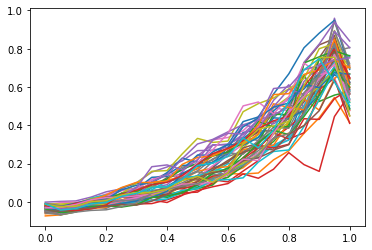

In [0]:
    #Testing code
    env = random_walk_env()
    policy = move_policy()
    coarse_coding = interval_coding(start = 0.0, end = 1.0, ntiles = 10, ntilings = 10)
    gamma = 1.0
    lam = 0.1
    alpha = 0.02
    nweights = coarse_coding.feature_size()
    td_lambda = td_lambda_predictor(gamma, lam, alpha, coarse_coding)
    v = td_lambda.training(env, policy, 25)

    nruns = 50

    td_lambdas = [td_lambda_predictor(gamma, lam, alpha, coarse_coding) for i in range(nruns) ]
    for i in range(nruns):
        td_lambdas[i].training(env, policy, 25)
    
    x = np.linspace(0, 1, 21)

    for i in range(nruns):
        plt.plot(x, [td_lambdas[i].estimate(y) for y in x])


    print(v)
    print(td_lambda.estimate(0.9))